In [1]:
# Aca resolvemos una ODE con condición inicial
# Problema 2 del articulo
# Artificial Neural Networks for Solving Ordinary and Partial Differential Equations

importamos los paquetes necesarios para el entrenamiento

In [2]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

Se resuelve la ecuación diferencial 

\begin{align}
\frac{d^2}{dx^2} \psi(x) + \frac{1}{5} \frac{d}{dx} \psi(x) + \psi(x)&= -\frac{1}{5} e^{-\frac{x}{5}} \cos(x) \\
\end{align}

definición de la arquitectura de la red neuronal

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(1, 50)
        self.linear2 = nn.Linear(50, 124)
        self.linear3 = nn.Linear(124, 256)
        self.linear4 = nn.Linear(256, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        x = self.linear4(x)
        return x

Definición los modelos

In [4]:
N = Model()
N_bc = Model()

Para

$\psi_t(x) = x + x^2N$

In [5]:
A = 0
B = 1
Psi_estimate = lambda x: A+ B*x + x**2*N(x)


Para

$\psi_t(x) = x\sin(1)e^{-\frac{1}{5}} + x(1-x)N$

In [6]:
A_bc = 0
B_bc = (torch.sin(torch.tensor(1))*torch.exp(torch.tensor(-1/5))).item()
Psi_estimate_bc = lambda x: A_bc*(1 - x) + B_bc*x + x*(1 - x)*N_bc(x)

In [7]:
# ahora definimos la funcion f(.)
f1 = lambda Psi, dPsi: dPsi/5 + Psi
f2 = lambda x: -torch.exp(-x/5)*torch.cos(x)/5

In [8]:
def loss(x, y):
    x.requires_grad = True
    outputs = y(x)
    Psi_estimate_x = torch.autograd.grad(outputs,x, grad_outputs=torch.ones_like(outputs),create_graph=True)[0] # esta es la derivada de Psi con respecto a x, i.e., dPsi/dx
    dPsi_estimate_x = torch.autograd.grad(Psi_estimate_x,x, grad_outputs=torch.ones_like(Psi_estimate_x),create_graph=True)[0] # esta es la segunda derivada de Psi con respecto a x, i.e., d^2Psi/dx^2
    return torch.mean((dPsi_estimate_x + f1(outputs, Psi_estimate_x) - f2(x))**2)


In [9]:
optimizer = torch.optim.LBFGS(N.parameters())
optimizer_bc = torch.optim.LBFGS(N_bc.parameters())

In [10]:
x = torch.Tensor(np.linspace(0,2,100)[:,None])

In [11]:
def closure():
    optimizer.zero_grad()
    l = loss(x, Psi_estimate)
    l.backward()
    return l

def closure_bc():
    optimizer_bc.zero_grad()
    l = loss(x, Psi_estimate_bc)
    l.backward()
    return l

for i in range(10):
    optimizer.step(closure)
    optimizer_bc.step(closure_bc)


### Comparación de resultados

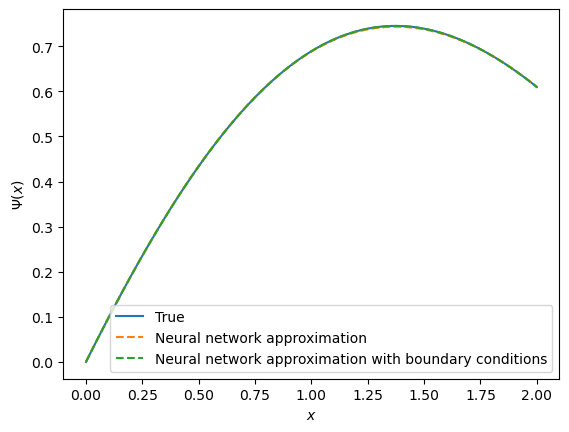

In [14]:
xx = np.linspace(0,2,100)[:,None]

with torch.no_grad():
    yy = Psi_estimate(torch.Tensor(xx)).numpy()
    yy_bc = Psi_estimate_bc(torch.Tensor(xx)).numpy()
    
yt = np.exp(-xx/5)*np.sin(xx)

fig, ax = plt.subplots(dpi=100)
ax.plot(xx,yt,label='True')
ax.plot(xx,yy,'--',label='Neural network approximation')
ax.plot(xx,yy_bc,'--',label='Neural network approximation with boundary conditions')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(loc='best')